In [1]:
%pip install numpy

Note: you may need to restart the kernel to use updated packages.


You should consider upgrading via the 'C:\Users\Dell\AppData\Local\Microsoft\WindowsApps\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\python.exe -m pip install --upgrade pip' command.


In [2]:
%pip install pydlm

Note: you may need to restart the kernel to use updated packages.


You should consider upgrading via the 'C:\Users\Dell\AppData\Local\Microsoft\WindowsApps\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\python.exe -m pip install --upgrade pip' command.


In [3]:
%pip install pandas

Note: you may need to restart the kernel to use updated packages.


You should consider upgrading via the 'C:\Users\Dell\AppData\Local\Microsoft\WindowsApps\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\python.exe -m pip install --upgrade pip' command.


In [4]:
%pip install openpyxl


Note: you may need to restart the kernel to use updated packages.


You should consider upgrading via the 'C:\Users\Dell\AppData\Local\Microsoft\WindowsApps\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\python.exe -m pip install --upgrade pip' command.


In [5]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [6]:
#import data
df = pd.read_csv('../Datasets/AMD Historical Data.csv')

#print data 
df.head()

,Date,Price,Open,High,Low,Vol.,Change %
0,1/3/2017,11.43,11.42,11.65,11.02,55.18M,0.79%
1,1/4/2017,11.43,11.45,11.52,11.23,40.78M,0.00%
2,1/5/2017,11.24,11.43,11.69,11.23,38.86M,-1.66%
3,1/6/2017,11.32,11.29,11.49,11.11,34.45M,0.71%
4,1/9/2017,11.49,11.37,11.64,11.31,37.30M,1.50%


In [7]:
#Bỏ dòng bị trống dự liệu
df = df.dropna()
#Chuyển đổi dữ liệu cột Vol. sang số
df['Vol.'] = df['Vol.'].str.replace('M', '').astype(float) * 1000000


In [8]:
df

,Date,Price,Open,High,Low,Vol.,Change %
0,1/3/2017,11.43,11.42,11.65,11.02,55180000.0,0.79%
1,1/4/2017,11.43,11.45,11.52,11.23,40780000.0,0.00%
2,1/5/2017,11.24,11.43,11.69,11.23,38860000.0,-1.66%
3,1/6/2017,11.32,11.29,11.49,11.11,34450000.0,0.71%
4,1/9/2017,11.49,11.37,11.64,11.31,37300000.0,1.50%
...,...,...,...,...,...,...,...
1606,5/22/2023,108.00,104.68,108.79,103.49,65110000.0,2.06%
1607,5/23/2023,108.12,107.25,110.99,107.19,72880000.0,0.11%
1608,5/24/2023,108.27,105.98,108.91,105.64,60390000.0,0.14%
1609,5/25/2023,120.35,117.31,120.69,115.80,107560000.0,11.16%


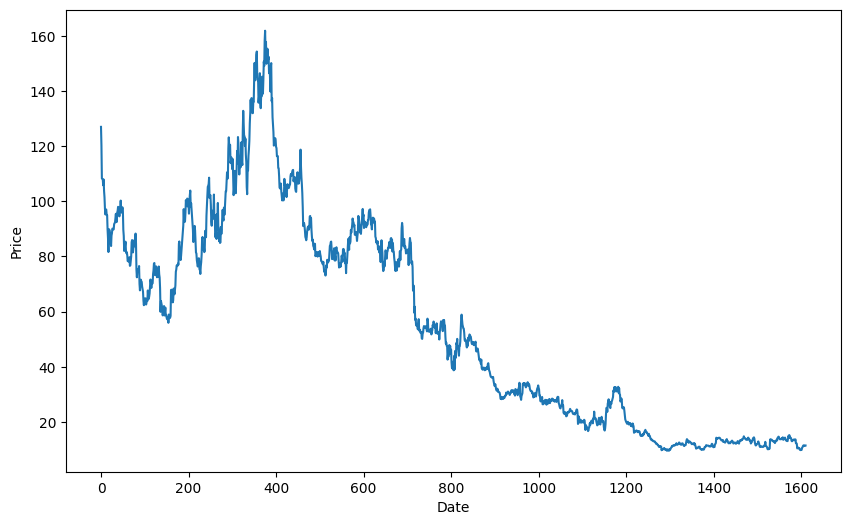

In [9]:
#Đảo ngược dữ liệu cho mô hình
df = df[::-1]

figure=df['Price'].values
plt.figure(figsize=(10,6))
plt.plot(figure)
plt.xlabel('Date')
plt.ylabel('Price') 
plt.show()

In [10]:
#Xây dựng mô hỉnh với Bayesian Dynamic Linear Model
from pydlm import dlm, trend, seasonality, dynamic, autoReg, longSeason


In [11]:
df = df.reset_index(drop=True)
 # Reset the index

# Split the data into training, testing, and validation sets
train_size = int(0.7 * len(df))
test_size = int(0.2 * len(df))
val_size = len(df) - train_size - test_size

train_data = df[:train_size]
test_data = df[train_size:train_size+test_size]
val_data = df[train_size+test_size:]

In [12]:
from pydlm import dlm, trend, seasonality

# Tạo model DLM
my_dlm = dlm(train_data['Price'])

# Thêm trend component
my_dlm = my_dlm + trend(degree=1, name='trend', w=1.0)

# Thêm seasonality component với chu kỳ 52 tuần
my_dlm = my_dlm + seasonality(period=52, name='season', w=1.0)

In [13]:

# Fit the DLM to the training data
my_dlm.fit()


Initializing models...
Initialization finished.
Starting forward filtering...
Forward filtering completed.
Starting backward smoothing...
Backward smoothing completed.


In [14]:
# Predict on validation set
my_dlm.predictN(N=30)


([17.17911009815592,
  17.412941505727687,
  17.299636092373632,
  16.5935023084396,
  16.96530966004251,
  16.621783630101437,
  16.79870725185986,
  17.02352084408538,
  17.070831275039804,
  17.01953235942478,
  16.889968932175204,
  17.10808617766434,
  17.198296230420127,
  17.22856683824272,
  16.460354201136205,
  14.984972874331092,
  15.174053481624718,
  15.804345705046149,
  15.273700938211519,
  15.201780236630391,
  15.269465816180887,
  15.728220424170479,
  15.478099844024431,
  14.46929774802396,
  14.780340824596008,
  14.507156311128703,
  14.604496688638804,
  14.332353901861923,
  15.075593480738533,
  15.145595689104805],
 [210.20636483449084,
  209.37495960302536,
  208.55127614034524,
  207.7352372114289,
  206.92676619575485,
  206.12578708941788,
  205.33222450702885,
  204.54600368340436,
  203.76705047504828,
  202.9952913614347,
  202.23065344609483,
  201.4730644575119,
  200.72245274983283,
  199.9787473033951,
  199.24187772507986,
  198.5117742484905,
  

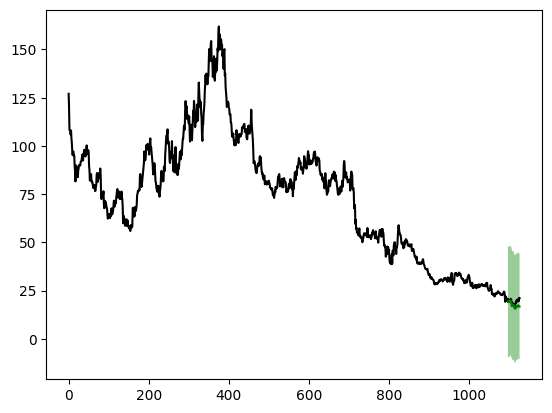

In [15]:
#Dự đoán trên tập train
my_dlm.plotPredictN(N=30, date=my_dlm.n-30)


In [16]:
# Predict on validation data
val_preds, val_vars = my_dlm.predictN(N=val_size)

# Predict on test data
test_preds, test_vars = my_dlm.predictN(N=test_size)
# Predict on train data
train_preds, train_vars = my_dlm.predictN(N=train_size)

In [18]:
# Các giá trị thực tế cho validation, test và train data
val_actual = val_data['Price'].values
test_actual = test_data['Price'].values
train_actual = train_data['Price'].values

In [19]:
%pip install scikit-learn


Note: you may need to restart the kernel to use updated packages.


You should consider upgrading via the 'C:\Users\Dell\AppData\Local\Microsoft\WindowsApps\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\python.exe -m pip install --upgrade pip' command.


In [20]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, mean_squared_error, mean_absolute_error

# Regression metrics
test_rmse = np.sqrt(np.mean((test_preds - test_actual)**2))
test_mse = mean_squared_error(test_actual, test_preds)
test_mae = mean_absolute_error(test_actual, test_preds)

valid_rmse = np.sqrt(np.mean((val_preds - val_actual)**2))
valid_mse = mean_squared_error(val_actual, val_preds)
valid_mae = mean_absolute_error(val_actual, val_preds)

print('Testing RMSE:', test_rmse)
print('Testing MSE:', test_mse)
print('Testing MAE:', test_mae)

print('Validation RMSE:', valid_rmse)
print('Validation MSE:', valid_rmse)
print('Validation MAE:', valid_mae)

Testing RMSE: 16.097772655145953
Testing MSE: 259.1382844567648
Testing MAE: 14.69603315298298
Validation RMSE: 5.959830341127736
Validation MSE: 5.959830341127736
Validation MAE: 4.802994731578914


In [25]:
# 6. Quá trình tạo index predict 30 ngày tiếp theo
last_index =  df.index[-1]
last_data = pd.RangeIndex(start=last_index, stop=last_index+30, step=1)

In [31]:
# Dự đoán 30 ngày tiếp theo sau tập validation
future_preds, future_vars = my_dlm.predictN(N=30)

# In ra dự đoán cho 30 ngày tiếp theo
print("Predictions for the next 30 days:")
print(future_preds)

Predictions for the next 30 days:
[17.17911009815592, 17.412941505727687, 17.299636092373632, 16.5935023084396, 16.96530966004251, 16.621783630101437, 16.79870725185986, 17.02352084408538, 17.070831275039804, 17.01953235942478, 16.889968932175204, 17.10808617766434, 17.198296230420127, 17.22856683824272, 16.460354201136205, 14.984972874331092, 15.174053481624718, 15.804345705046149, 15.273700938211519, 15.201780236630391, 15.269465816180887, 15.728220424170479, 15.478099844024431, 14.46929774802396, 14.780340824596008, 14.507156311128703, 14.604496688638804, 14.332353901861923, 15.075593480738533, 15.145595689104805]


In [21]:
#Tạo một mảng chứa toàn bộ dữ liệu của tập train, validation và test
allPreds = np.concatenate([train_preds,test_preds, val_preds])


In [22]:
#Tạo mảng index tương ứng với tập allPreds
days = np.arange(0, len(allPreds))


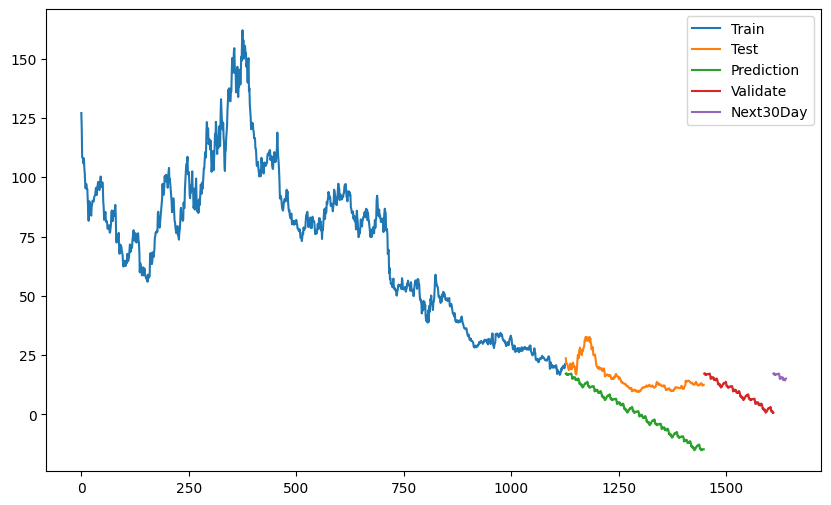

In [39]:
#Vẽ hình
plt.figure(figsize=(10, 6))
plt.plot(train_data.index, train_data['Price'])
plt.plot(test_data.index, test_data['Price'])
#plt.plot(val_data.index, val_data['Price'])
plt.plot(days[len(train_data.index):len(train_data.index)+len(test_preds)], test_preds, label='Prediction')
plt.plot(days[len(train_data.index)+len(test_preds):], val_preds, label='Validate')
plt.plot(last_data,future_preds, label='Next30Day')

#plt.plot(pred_df.index, pred_df['Price'], label='Predicted')
plt.legend(['Train', 'Test', 'Prediction', 'Validate', 'Next30Day'])
plt.show()